In [18]:
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Get data from OpenPrescribing GBG measure equivalent view

In [19]:
sql = """
SELECT
  month,
  pct,
  practice,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS possible_savings,
  SUM(net_cost) AS net_cost
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
GROUP BY
  month,
  pct,
  practice
"""
ghost_df = bq.cached_read(sql, csv_path='ghost_generics.zip')

In [20]:
ghost_df.head()

,month,pct,practice,items,possible_savings,net_cost
0,2015-08-01,06N,E82020,3,-15.61,37280.74
1,2015-08-01,00X,P81010,5,3.65,29541.43
2,2015-08-01,01A,P81620,0,0.00,7382.23
3,2015-08-01,00V,P83620,12,0.07,34162.02
4,2015-08-01,00V,P83005,1,2.94,35156.08


# Practice level data

In [21]:
practice = ghost_df.copy()
practice['calc_val'] = practice['possible_savings']/practice['net_cost']
practice['month'] = pd.to_datetime(practice['month'])
practice = practice.sort_values(['practice','month'])
practice = practice.loc[practice['month']>='2013-05-01']
practice = practice.replace([np.inf, -np.inf], np.nan)
practice.head()

,month,pct,practice,items,possible_savings,net_cost,calc_val
665160,2013-05-01,00K,A81001,3,3.29,32027.35,0.00
321303,2013-06-01,00K,A81001,3,-2.13,27785.40,-0.00
582074,2013-07-01,00K,A81001,0,0.00,30353.65,0.00
275536,2013-08-01,00K,A81001,3,3.35,30748.65,0.00
712293,2013-09-01,00K,A81001,1,32.18,29544.21,0.00


# CCG level data

In [22]:
ccg = ghost_df.copy()
ccg['month'] = pd.to_datetime(ccg['month'])
ccg = ccg.groupby(['pct','month'],as_index=False).sum()
ccg['calc_val'] = ccg['possible_savings']/ccg['net_cost']
ccg = ccg.sort_values(['pct','month'])
ccg = ccg.loc[ccg['month']>='2013-05-01']
ccg = ccg.replace([np.inf, -np.inf], np.nan)
ccg.head()

,pct,month,items,possible_savings,net_cost,calc_val
33,00C,2013-05-01,1599,182.10,837980.56,0.00
34,00C,2013-06-01,937,262.12,765673.64,0.00
35,00C,2013-07-01,723,597.99,838610.10,0.00
36,00C,2013-08-01,775,107.67,815297.72,0.00
37,00C,2013-09-01,815,229.13,771885.32,0.00


In [23]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [24]:
## here we calculate ranges for december 2012
ccg_dec18 = ccg.copy().loc[(ccg["month"]== "2018-12-01")]
ccg_dec18.describe()

,items,possible_savings,net_cost,calc_val
count,196.00,196.00,196.00,196.00
mean,14252.16,4430.38,1784261.53,0.00
std,20319.74,6088.59,1046548.64,0.00
min,71.00,-197.52,50003.30,-0.00
25%,568.50,72.26,1150486.67,0.00
50%,4477.50,1590.20,1523225.40,0.00
75%,21404.00,6701.10,2073027.21,0.00
max,142769.00,34664.49,7234775.70,0.02


# Most recent month map
- I think still some missing CCGs here?

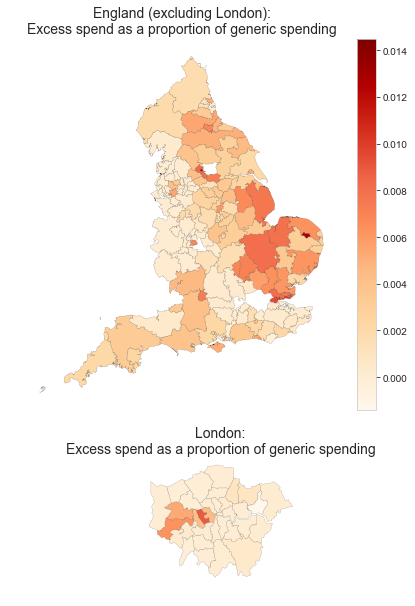

In [26]:
plt.figure(figsize=(7, 10))
last_month = ccg.loc[ccg['month']==ccg['month'].max()]
maps.ccg_map(last_month, title="Excess spend as a proportion of generic spending", column='calc_val', 
             separate_london=True)
plt.show()

# Declie plots

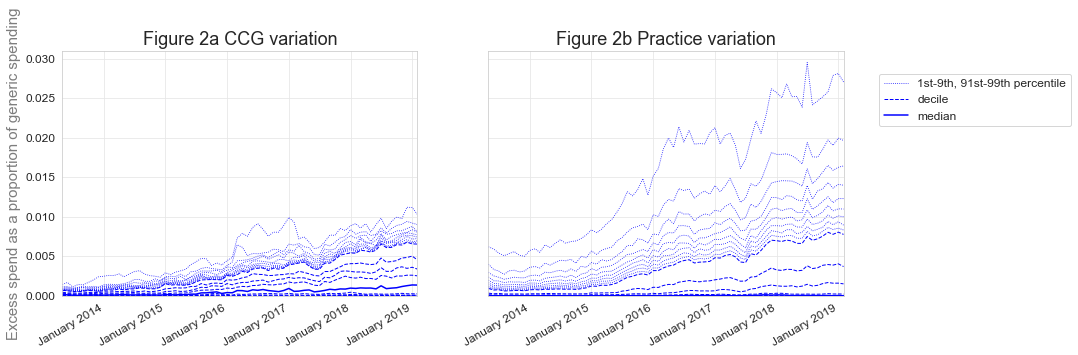

In [66]:
f = plt.figure(figsize=(14, 5))
#f.suptitle('Sharing Y axis')
f.autofmt_xdate()
layout = gridspec.GridSpec(1, 2, figure=f)
left_plot = plt.subplot(layout[0])
right_plot = plt.subplot(layout[1], sharey=left_plot)  # Share the Y axis 
# ...and because it's shared, suppress ticks on the second chart
plt.setp(right_plot.get_yticklabels(), visible=False)  

charts.deciles_chart(
    ccg,
    period_column='month',
    column='calc_val',
    title="Figure 2a CCG variation",
    ylabel="Excess spend as a proportion of generic spending",
    show_outer_percentiles=True,
    show_legend=False,
    ax=left_plot
)

charts.deciles_chart(
    practice,
    period_column='month',
    column='calc_val',
    title="Figure 2b Practice variation",
    ylabel="",
    show_outer_percentiles=True,
    show_legend=True,
    ax=right_plot
)
plt.savefig('deciles.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

# Total items and total excess costs

In [55]:
totals = practice.groupby('month').sum()

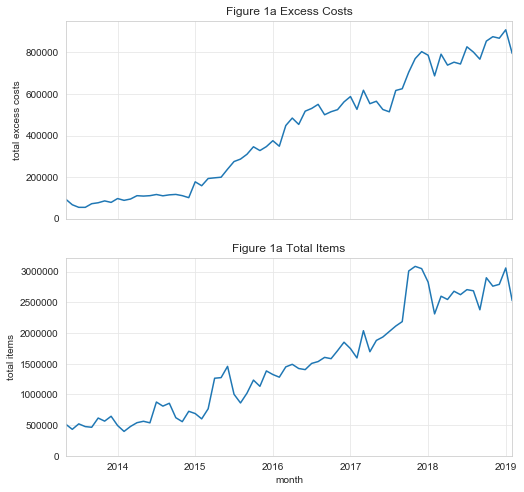

In [65]:
f = plt.figure(figsize=(8, 8))
layout = gridspec.GridSpec(2, 1, figure=f)
top_plot = plt.subplot(layout[0])
bottom_plot = plt.subplot(layout[1], sharex=top_plot)  # Share the Y axis 

ax = totals['possible_savings'].plot(ax=top_plot)
ax.set_ylabel('total excess costs')
ax.set_ylim(0,)
ax.set_title('Figure 1a Excess Costs')
ax = totals['items'].plot(ax=bottom_plot)
ax.set_ylabel('total items')
ax.set_ylim(0,)
ax.set_title('Figure 1a Total Items')
plt.savefig('Fig 1.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

## Annual totals
Ignore 2013 and 2019, as they're not complete years

In [63]:
totals[['items','possible_savings','net_cost']].resample('Y').sum()

,items,possible_savings,net_cost
month,,,
2013-12-31,4230540,579186.29,2923176703.55
2014-12-31,7451006,1275098.39,4399345122.25
2015-12-31,12682756,3052386.53,4653745679.59
2016-12-31,18160750,5807246.05,4538026084.68
2017-12-31,26362166,7409786.86,4548889822.26
2018-12-31,31827681,9496024.33,4220776576.84
2019-12-31,5587090,1703622.52,682792352.21


# Stratify by EHR

In [85]:
epr = pd.read_csv("gpsoc_marketshare_201801b.csv.gz", compression='gzip', usecols=['ODS', 'Principal Supplier', 'Principal System'])
epr.loc[epr['Principal Supplier']=='TPP','Principal Supplier'] = 'SystmOne'
epr.head()

,ODS,Principal Supplier,Principal System
0,A81023,SystmOne,SystmOne
1,A81048,SystmOne,SystmOne
2,A82018,EMIS,EMIS Web
3,A84043,SystmOne,SystmOne
4,A86026,SystmOne,SystmOne


In [86]:
numbers = practice[['month','practice', 'possible_savings','net_cost']]
by_epr = numbers.merge(epr, how='inner', left_on='practice', right_on='ODS')
by_epr = by_epr.groupby(['month','Principal Supplier']).sum() ### Alex I replaced ssupplier with system. Do you think this is good apprach or should I just change the value TPP to SystmOne?
by_epr = by_epr.unstack()
by_epr.head()

possible_savings                                net_cost  \
Principal Supplier             EMIS Microtest SystmOne  Vision         EMIS   
month                                                                         
2013-05-01                 10629.54   1493.93 72309.79 4399.63 200685395.35   
2013-06-01                  -107.94   1416.86 61288.79 1995.01 186092622.91   
2013-07-01                 -8165.18    649.79 59612.65 1271.25 200943446.00   
2013-08-01                 -1239.18    616.79 55016.82 1012.58 193292076.92   
2013-09-01                  9989.54    419.24 59891.55 1124.72 188399136.88   

                                                        
Principal Supplier  Microtest     SystmOne      Vision  
month                                                   
2013-05-01         3090882.96 136987480.54 15943293.46  
2013-06-01         2845649.77 126617736.54 14883351.16  
2013-07-01         3123498.91 136497036.23 15956182.22  
2013-08-01         3057964.42 131969020.47 15349534.74  
2013-09-01         2898094.28 127861954.78 15047491.22

## Total possible savings

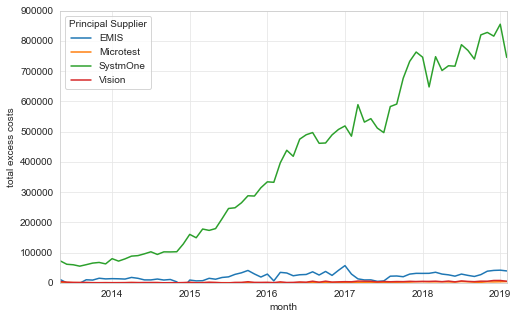

In [87]:
f = plt.figure(figsize=(8, 5))
layout = gridspec.GridSpec(1, 1, figure=f)
ax = plt.subplot(layout[0])
ax = by_epr['possible_savings'].plot(ax=ax)
ax.set_ylabel('total excess costs')
ax.set_ylim(0,)
plt.savefig('savings_by_EHR.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

## Total savings/total generic prescribing costs

In [88]:
measure = by_epr['possible_savings'] / by_epr['net_cost']
measure.head()

Principal Supplier,EMIS,Microtest,SystmOne,Vision
month,,,,
2013-05-01,0.00,0.00,0.00,0.00
2013-06-01,-0.00,0.00,0.00,0.00
2013-07-01,-0.00,0.00,0.00,0.00
2013-08-01,-0.00,0.00,0.00,0.00
2013-09-01,0.00,0.00,0.00,0.00


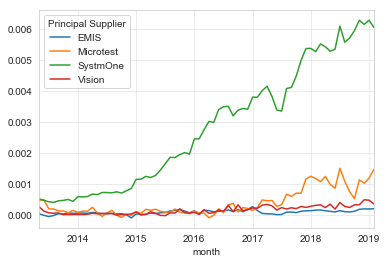

In [89]:
measure.plot()

# SystmOne Only

In [33]:
systmone = by_epr['possible_savings'].drop(["EMIS Web", "Evolution", "Vision 3 Hosted", "Vision 3 LAN"], axis=1)
systmone.head()

Principal System,SystmOne
month,
2013-05-01,72309.79
2013-06-01,61288.79
2013-07-01,59612.65
2013-08-01,55016.82
2013-09-01,59891.55


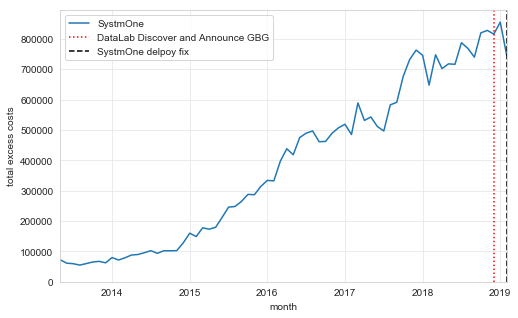

In [79]:
f = plt.figure(figsize=(8, 5))
layout = gridspec.GridSpec(1, 1, figure=f)
ax = plt.subplot(layout[0])
ax = systmone.plot(ax=ax)
ax.axvline('2018-12-01',color='r',linestyle=':', label='DataLab Discover and Announce GBG')
ax.axvline('2019-02-01',color='k',linestyle='--', label='SystmOne delpoy fix') ## it was last week of Feb, I think a case for setting as march
ax.set_ylabel('total excess costs')
ax.set_ylim(0,)
ax.legend()
plt.savefig('systmone_only.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

# Top ten GBG chemicals in 2018

In [49]:
sql = """
WITH
  chem_map AS(
  SELECT
    DISTINCT chemical_code,
    chemical
  FROM
    ebmdatalab.hscic.bnf)
SELECT
  SUBSTR(bnf_code,1,9) AS chem_code,
  chemical,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN items ELSE 0 END) AS items,
  SUM(CASE WHEN (possible_savings >= 2
    OR possible_savings <=-2) THEN possible_savings ELSE 0 END) AS excess_spend
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
LEFT JOIN
  chem_map
ON
  SUBSTR(bnf_code,1,9) = chemical_code
WHERE
  month >= '2018-01-01'
  AND month <= '2018-12-01'
GROUP BY
  chem_code,
  chemical
ORDER BY
  excess_spend DESC
"""
by_chem = bq.cached_read(sql, csv_path='by_chem.zip')

In [53]:
by_chem.head(10)

,chem_code,chemical,items,excess_spend
0,0212000B0,Atorvastatin,5559934,1694636.00
1,0408010AE,Pregabalin,159404,665385.00
2,0411000G0,Memantine Hydrochloride,100178,512713.00
3,0303020G0,Montelukast,241626,298154.00
4,0402010AD,Aripiprazole,18605,269940.00
5,0205052N0,Losartan Potassium,786568,269048.00
6,0402010AB,Quetiapine,89215,235940.00
7,0206020A0,Amlodipine,2719024,219620.00
8,0403010X0,Trazodone Hydrochloride,26253,213471.00
9,0603020T0,Prednisolone,103825,180959.00


In [52]:
by_chem.sort_values('items',ascending=False).head(10)

,chem_code,chemical,items,excess_spend
0,0212000B0,Atorvastatin,5559934,1694635.63
16,0103050P0,Omeprazole,3664839,133583.12
13,0103050L0,Lansoprazole,2827832,153589.42
7,0206020A0,Amlodipine,2719024,219620.47
46,0601022B0,Metformin Hydrochloride,1283610,39942.21
24,0204000H0,Bisoprolol Fumarate,1186282,102676.65
12,0209000C0,Clopidogrel,1130301,167058.98
32,0212000Y0,Simvastatin,1002033,60841.19
59,040702040,Tramadol Hydrochloride,985668,30974.86
47,0602010V0,Levothyroxine Sodium,889756,39727.58
